In [1]:
%matplotlib inline


# Different classifiers in decoding the Haxby dataset

Here we compare different classifiers on a visual object recognition
decoding task. Please first run the decoding_basic script to understand the main steps.


## Loading the data



This part again loads the data. In that case, we confine the decoding analysis to a region of interest (ROI), by using a spatial mask. We consider data from the 8 non-rest categories to perform multi-calss classification.

In [2]:
# We start by loading data using nilearn dataset fetcher
from nilearn import datasets
from nilearn.image import get_data
# by default 2nd subject data will be fetched
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print('First subject anatomical nifti image (3D) located is at: %s' %
      haxby_dataset.anat[0])
print('First subject functional nifti image (4D) is located at: %s' %
      haxby_dataset.func[0])

# load labels
import numpy as np
import pandas as pd
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
stimuli = labels['labels']

# identify resting state (baseline) labels in order to be able to remove them
resting_state = (stimuli == 'rest')

# extract the indices of the images corresponding to some condition or task
task_mask = np.logical_not(resting_state)

# find names of remaining active labels
categories = stimuli[task_mask].unique()

# extract tags indicating to which acquisition run a tag belongs
session_labels = labels['chunks'][task_mask]


# Load the fMRI data
# For decoding, standardizing is often very important
mask_filename = haxby_dataset.mask_vt[0]
func_filename = haxby_dataset.func[0]


# Because the data is in one single large 4D image, we need to use
# index_img to do the split easily.
from nilearn.image import index_img
fmri_niimgs = index_img(func_filename, task_mask)
classification_target = stimuli[task_mask]

First subject anatomical nifti image (3D) located is at: C:\Users\yugos/nilearn_data\haxby2001\subj2\anat.nii.gz
First subject functional nifti image (4D) is located at: C:\Users\yugos/nilearn_data\haxby2001\subj2\bold.nii.gz


## Training the decoder



For each classifier used, we instantiate a decoder object that will perform the classification. Please take time to look at the Decoder's API.

In [3]:
# Then we define the various classifiers that we use
classifiers = ['svc_l2', 'svc_l1', 'logistic_l1',
               'logistic_l2', 'ridge_classifier']

# Here we compute prediction scores and run time for all these
# classifiers
import time
from nilearn.decoding import Decoder
from sklearn.model_selection import LeaveOneGroupOut

cv = LeaveOneGroupOut()
classifiers_data = {}

for classifier_name in sorted(classifiers):
    print(70 * '_')

    # The decoder has as default score the `roc_auc`
    decoder = Decoder(estimator=classifier_name, mask=mask_filename,
                      standardize=True, cv=cv)
    t0 = time.time()
    decoder.fit(fmri_niimgs, classification_target, groups=session_labels)

    classifiers_data[classifier_name] = {}
    classifiers_data[classifier_name]['score'] = decoder.cv_scores_

    print("%10s: %.2fs" % (classifier_name, time.time() - t0))
    for category in categories:
        print("    %14s vs all -- AUC: %1.2f +- %1.2f" % (
            category,
            np.mean(classifiers_data[classifier_name]['score'][category]),
            np.std(classifiers_data[classifier_name]['score'][category]))
        )

    # Adding the average performance per estimator
    scores = classifiers_data[classifier_name]['score']
    scores['AVERAGE'] = np.mean(list(scores.values()), axis=0)
    classifiers_data[classifier_name]['score'] = scores

______________________________________________________________________
logistic_l1: 37.34s
          scissors vs all -- AUC: 0.92 +- 0.05
              face vs all -- AUC: 0.98 +- 0.02
               cat vs all -- AUC: 0.96 +- 0.04
              shoe vs all -- AUC: 0.92 +- 0.08
             house vs all -- AUC: 1.00 +- 0.00
      scrambledpix vs all -- AUC: 0.99 +- 0.01
            bottle vs all -- AUC: 0.90 +- 0.08
             chair vs all -- AUC: 0.91 +- 0.06
______________________________________________________________________
logistic_l2: 84.08s
          scissors vs all -- AUC: 0.91 +- 0.08
              face vs all -- AUC: 0.97 +- 0.04
               cat vs all -- AUC: 0.97 +- 0.03
              shoe vs all -- AUC: 0.92 +- 0.09
             house vs all -- AUC: 1.00 +- 0.00
      scrambledpix vs all -- AUC: 0.96 +- 0.11
            bottle vs all -- AUC: 0.82 +- 0.18
             chair vs all -- AUC: 0.89 +- 0.18
__________________________________________________________________

## Visualization



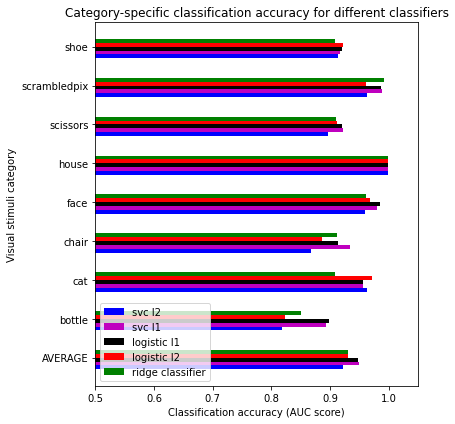

In [4]:
# Then we make a rudimentary diagram
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))

all_categories = np.sort(np.hstack([categories, 'AVERAGE']))
tick_position = np.arange(len(all_categories))
plt.yticks(tick_position + 0.25, all_categories)
height = 0.1

for i, (color, classifier_name) in enumerate(zip(['b', 'm', 'k', 'r', 'g'],
                                                 classifiers)):
    score_means = [
        np.mean(classifiers_data[classifier_name]['score'][category])
        for category in all_categories
    ]

    plt.barh(tick_position, score_means,
             label=classifier_name.replace('_', ' '),
             height=height, color=color)
    tick_position = tick_position + height

plt.xlabel('Classification accuracy (AUC score)')
plt.ylabel('Visual stimuli category')
plt.xlim(xmin=0.5)
plt.legend(loc='lower left', ncol=1)
plt.title(
    'Category-specific classification accuracy for different classifiers')
plt.tight_layout()

We can see that for a fixed penalty the results are similar between the svc
and the logistic regression. The main difference relies on the penalty
($\ell_1$ and $\ell_2$). The sparse penalty works better because we are in
an intra-subject setting.



## Visualizing the face vs house map

Restrict the decoding to face vs house



In [5]:
condition_mask = np.logical_or(stimuli == 'face', stimuli == 'house')
stimuli = stimuli[condition_mask]
assert len(stimuli) == 216
fmri_niimgs_condition = index_img(func_filename, condition_mask)
session_labels = labels['chunks'][condition_mask]
categories = stimuli.unique()
assert len(categories) == 2

for classifier_name in sorted(classifiers):
    decoder = Decoder(estimator=classifier_name, mask=mask_filename,
                      standardize=True, cv=cv)
    decoder.fit(fmri_niimgs_condition, stimuli, groups=session_labels)
    classifiers_data[classifier_name] = {}
    classifiers_data[classifier_name]['score'] = decoder.cv_scores_
    classifiers_data[classifier_name]['map'] = decoder.coef_img_['face']

Finally, we plot the face vs house map for the different classifiers
Use the average EPI as a background



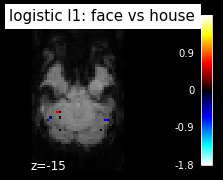

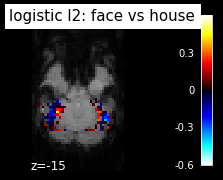

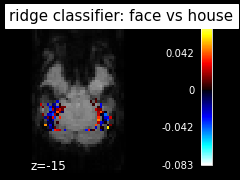

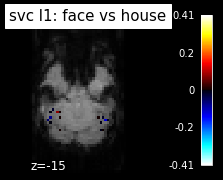

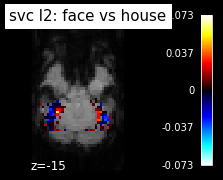

In [6]:
from nilearn.image import mean_img
from nilearn.plotting import plot_stat_map, show
mean_epi_img = mean_img(func_filename)

for classifier_name in sorted(classifiers):
    coef_img = classifiers_data[classifier_name]['map']
    threshold = np.max(np.abs(get_data(coef_img))) * 1e-3
    plot_stat_map(
        coef_img, bg_img=mean_epi_img, display_mode='z', cut_coords=[-15],
        threshold=threshold,
        title='%s: face vs house' % classifier_name.replace('_', ' '))

show()